<a href="https://colab.research.google.com/github/teeloren/CC-Project/blob/main/Farmers_Market2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Question: Are NYS Farmers Markets serving the communities most in need?

# Farmers Market Dataset
    # Source: https://data.ny.gov/Economic-Development/Farmers-Markets-in-New-York-State/qq4h-8p86
    # Data File Layout: https://data.ny.gov/api/assets/E62C8927-62E5-4D23-A03B-BF9AB1BA006D?download=true
    # Data File Summary: https://data.ny.gov/api/assets/52CA6FF7-C560-4635-8B6A-4196A9F1BF93?download=true
  
# Poverty By County Dataset
    # Source: https://www.census.gov/data-tools/demo/saipe/#/?map_geoSelector=aa_c&s_state=36&s_year=2020

# Regions of NY Dataset
    # Source: https://data.ny.gov/Economic-Development/Labor-Market-Regions/imem-myat

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
##### DATASETS #####

# Farmers Market [Shape:(579, 20)]
dfmarket = pd.read_csv('https://raw.githubusercontent.com/teeloren/CC-Project/main/Farmers__Markets_in_New_York_State%20(1).csv')

# County Economic [Shape:(64, 44)]
dfcounty = pd.read_csv('https://raw.githubusercontent.com/teeloren/CC-Project/main/SAIPESNC_16MAY22_16_32_58_86.csv')

# Regions [Shape:(62,2)]
dfreg = pd.read_csv('https://raw.githubusercontent.com/teeloren/CC-Project/main/Labor_Market_Regions.csv')

In [4]:
##### CLEANING Farmers Market DATASET ######

# Any duplicate values?
dfmarket.duplicated().any() #False

# Any null values?
dfmarket.isnull().values.any()  #True
dfmarket.isnull().sum() #2 cols (Market Link: 146)(Operation Season 1)

# Cleaning null data found in Market Link and Operation Season columns
dfmarket = dfmarket.drop(['Market Link'], axis=1) # dropped Market Link column, not needed for charting 

# View null rows
nullrows = dfmarket[dfmarket['Operation Season'].isna()]

# Mode for the null column
dfmode =dfmarket['Operation Season'].mode()

# Filling null value with column mode
dfmarket.fillna(dfmarket['Operation Season'].mode()[0], inplace=True)

# Second check - Any null values?
dfmarket.isnull().values.any() # now False, replaced with column mode

# Dropping columns not needed for analysis
dfmarket = dfmarket.drop(['Market Location', 'Address Line 1', 'State','Contact', 'Phone', 'Latitude', 'Longitude', 'Georeference'], axis=1)

In [5]:
##### CLEANING County DATASET #####

# Limiting dataset to only columns needed for analysis
dfcounty_data = dfcounty[['State / County Name','All Ages SAIPE Poverty Universe','All Ages in Poverty Count', 'All Ages in Poverty Percent',
                   'Median Household Income in Dollars']]

# Only reviewing counties, removing rows with data for US and NYS
dfcounty_data = dfcounty_data.drop(index=0)
dfcounty_data = dfcounty_data.drop(index=1)

# Any duplicate values?
dfcounty_data.duplicated().any() #False

# Any null values?
dfcounty_data.isnull().values.any() #False

# Changing column Names
dfcounty_data.rename(columns = {'State / County Name':'County', 'All Ages SAIPE Poverty Universe':'Total Population', 'All Ages in Poverty Count':'Number in Poverty',
                                'All Ages in Poverty Percent':'Percent in Poverty', 'Median Household Income in Dollars':'Median Household Income'}, inplace = True)

# reformat Median Household Income, Total Population and Number in Poverty columns to int values
dfcounty_data["Median Household Income"] = dfcounty_data["Median Household Income"].str.replace("$","")
dfcounty_data["Median Household Income"] = dfcounty_data["Median Household Income"].str.replace(",","")
dfcounty_data['Median Household Income'] = dfcounty_data['Median Household Income'].astype(int)

dfcounty_data["Number in Poverty"] = dfcounty_data["Number in Poverty"].str.replace(",","")
dfcounty_data['Number in Poverty'] = dfcounty_data['Number in Poverty'].astype(float)

dfcounty_data["Total Population"] = dfcounty_data["Total Population"].str.replace(",","")
dfcounty_data['Total Population'] = dfcounty_data['Total Population'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [6]:
##### PREPARE DATASETS FOR MERGE w/FARMERS MARKET DATASET #####

# Farmers Market total by County
dfmarket_data = dfmarket.County.value_counts()

# Convert county to a dataframe
dfm = pd.DataFrame(dfmarket_data)

# Reset index so county name can be a column
dfm = dfm.reset_index()

# Rename columns
dfm.rename(columns = {'index':'County', 'County':'Farmers Market Count'}, inplace = True)

# Reformat County column by adding "County(NY)" to all values
dfm['County'] = dfm['County'].astype(str) + ' County (NY)'

In [7]:
##### CLEANING Regions Dataset  #####

# Reformat County column by adding "County(NY)" to all values
dfreg['County'] = dfreg['County'].astype(str) + ' County (NY)'

In [8]:
##### MERGING Farmers Markerts and County DATASETS #####

dfmerge = dfm.merge(dfcounty_data, left_on='County', right_on='County', how='outer')
    
dfreg_markets = dfreg.merge(dfmerge, left_on='County', right_on='County', how='outer')
    # Shape: (62, 7)

In [9]:
##### CLEANING Merged DATASETS #####

# Any null values?
dfreg_markets.isnull().values.any() #True 

# Column name with null values
dfreg_markets.isnull().sum() # 1 null value, Farmers Market Count 

# Any duplicate values?
dfreg_markets.duplicated().any() # False

# Replace null values with 0 (missing data for # of Farmers Market, wasnt in Farmers Market dataset)
dfreg_markets.fillna(0, inplace = True)

# Reformat Farmers Market Count column to int values
dfreg_markets['Farmers Market Count'] = dfreg_markets['Farmers Market Count'].astype('int')


In [10]:
##### Statistical Table #####

# Numerical columns for stats table
stats = dfreg_markets[['Farmers Market Count', 'Total Population','Number in Poverty', 'Percent in Poverty', 'Median Household Income']]

# Mean, median, max and min of the columns in the stats list
mean = stats.mean().round(1)
median = stats.median()
max = stats.max()
min = stats.min()

# Merge column stats into a table
stats_table = pd.concat([mean,median, min, max], axis=1)

# Renaming table columns
stats_table.rename(columns = {0:"Mean",1:"Median", 2:"Min", 3:"Max"}, inplace = True)

In [11]:
nys_total_pop = dfreg_markets['Total Population'].sum()
fm_total = dfreg_markets['Farmers Market Count'].sum()

dfreg_markets['Percent of Total Pop'] = (((dfreg_markets['Number in Poverty']/nys_total_pop)*100)/12.7)*100
dfreg_markets['Percent of Farmers Market'] = (dfreg_markets['Farmers Market Count']/fm_total)*100


regions = dfreg_markets.copy()
# regions = regions.drop(['County', 'Percent in Poverty', 'Percent in Poverty(NYS)'], axis=1)



nyregions = regions.groupby(regions.Region).sum()
nyregions = nyregions.reset_index()
nyregions = nyregions.sort_values(by='Farmers Market Count')



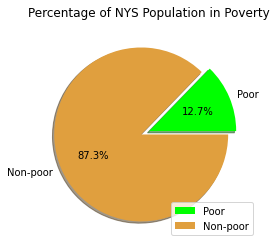

In [12]:
##### Percentage of NYS Population in Poverty #####

total_pop = dfreg_markets["Total Population"].sum()
poor = dfreg_markets["Number in Poverty"].sum()
non_poor = total_pop - poor

nys_pop = [poor,non_poor]
pop_labels = 'Poor', "Non-poor"
explode = (0,0.1)


plt.pie(nys_pop,labels=pop_labels, autopct='%1.1f%%' , explode=explode, shadow=True, colors=['#00FF00','#E09F3E'])
plt.title('Percentage of NYS Population in Poverty')
plt.legend(loc='lower right')
plt.show()

([<matplotlib.patches.Wedge at 0x7f75fcd9bbd0>,
 [Text(0.5344212311476375, 0.9614540798699872, 'Downstate'),
  Text(-0.5344212311476381, -0.9614540798699868, 'Upstate')],
 [Text(0.2915024897168932, 0.524429498110902, '34%'),
  Text(-0.29150248971689346, -0.5244294981109018, '66%')])

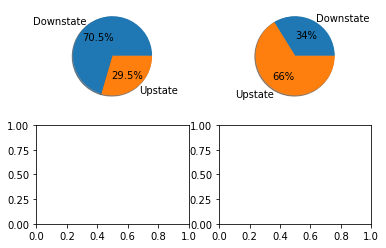

In [13]:
##### Breakdown of NYS Population in Poverty by Upstate and Downstate #####

downstate = nyregions[(nyregions.Region == "New York City") | (nyregions.Region == "Long Island") | (nyregions.Region == "Hudson Valley")]
upstate = nyregions[(nyregions.Region == "Southern Tier") | (nyregions.Region == "Mohawk Valley") 
          | (nyregions.Region == "Central New York") | (nyregions.Region == "North Country")
          | (nyregions.Region == "Finger Lakes")| (nyregions.Region == "Western New York")| (nyregions.Region == "Capital Region")]

# create double pie chart for upstate/downstate data

## Percent of NYS Poor by area
downstate_nys_poor = downstate['Percent of Total Pop'].sum()
upstate_nys_poor = upstate['Percent of Total Pop'].sum()

      # variables for chart
area_poor = [downstate_nys_poor,upstate_nys_poor]
area_poor_labels = 'Downstate','Upstate'

## Number in Poverty by area
downstate_num_poverty = downstate['Number in Poverty'].sum()
upstate_num_poverty = upstate['Number in Poverty'].sum()

      # variables for chart
area_num_poverty = [downstate_fm,upstate_fm]
area_num_poverty_labels = 'Downstate','Upstate'


## Percent of Farmers Market by area
downstate_fm = downstate['Percent of Farmers Market'].sum()
upstate_fm = upstate['Percent of Farmers Market'].sum()

      # variables for chart
area_fm = [downstate_fm,upstate_fm]
area_fm_labels = 'Downstate','Upstate'

## Dual Charts of Percentage of NYS Poor and FM by area
fig, axs = plt.subplots(2, 2)

axs[0, 0].pie(area_poor, labels=area_poor_labels, autopct='%1.1f%%', shadow=True)

axs[0, 1].pie(area_fm, labels=area_fm_labels, autopct='%.0f%%', shadow=True)

# plt.show()
# title='Percent of NYS Poor by area'
#  title='Percent of Farmers Market by area'

# # fig, (ax1, ax2) = plt.subplots(1, 2)

# # ax1.pie()
# # ax2.pie(downstate['Percent of Total Pop'])

# # plt.show()


# upstate['Percent of Total Pop'].sum()

In [14]:
upstate

,Region,Farmers Market Count,Total Population,Number in Poverty,Percent in Poverty,Median Household Income,Percent of Total Pop,Percent of Farmers Market
8,Southern Tier,27,592155.0,83690.0,102.8,450971,3.497640,4.663212
5,Mohawk Valley,36,458500.0,56966.0,74.1,344637,2.380769,6.217617
1,Central New York,37,736851.0,93215.0,60.8,306281,3.895717,6.390328
7,North Country,52,381843.0,49763.0,85.1,398825,2.079736,8.981002
2,Finger Lakes,75,1153844.0,144842.0,100.7,540968,6.053354,12.953368
9,Western New York,77,1333537.0,177970.0,71.1,269804,7.437866,13.298791
0,Capital Region,79,1042938.0,102434.0,80.4,546368,4.281005,13.644214


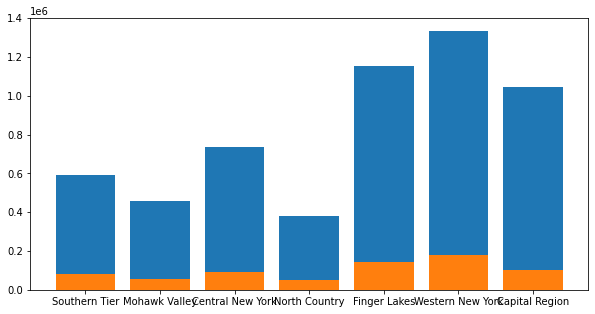

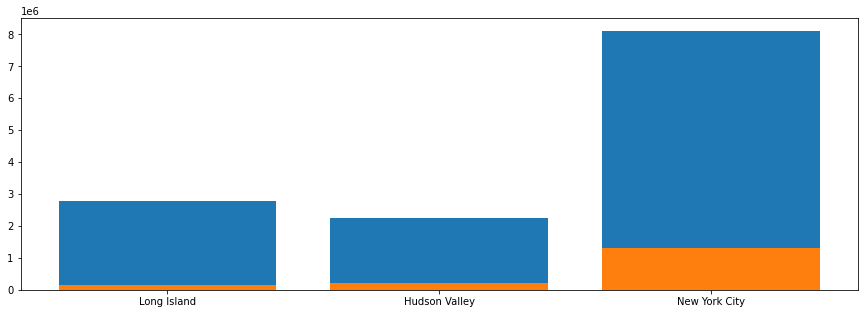

In [15]:
plt.figure(figsize=(10,5))
plt.bar(upstate['Region'],upstate['Total Population'])
plt.bar(upstate['Region'],upstate['Number in Poverty'])
plt.show()
plt.figure(figsize=(15,5))
plt.bar(downstate['Region'],downstate['Total Population'])
plt.bar(downstate['Region'],downstate['Number in Poverty'])
plt.show()


In [16]:
# sal = data[data['salary'] == '>50K']
# high_sal = sal['age']

# plt.figure(figsize=(22,14))
# plt.hist(high_sal, color='g', edgecolor='k')
# plt.rcParams.update({'font.size': 26})
# plt.xlabel('Age', )
# plt.ylabel('Total')
# plt.title('Age of Salary Earners Making 50K+')
# plt.ylim(0, 2250)
# plt.savefig('foo.png', dpi=300)
# plt.grid(True)
# plt.show()

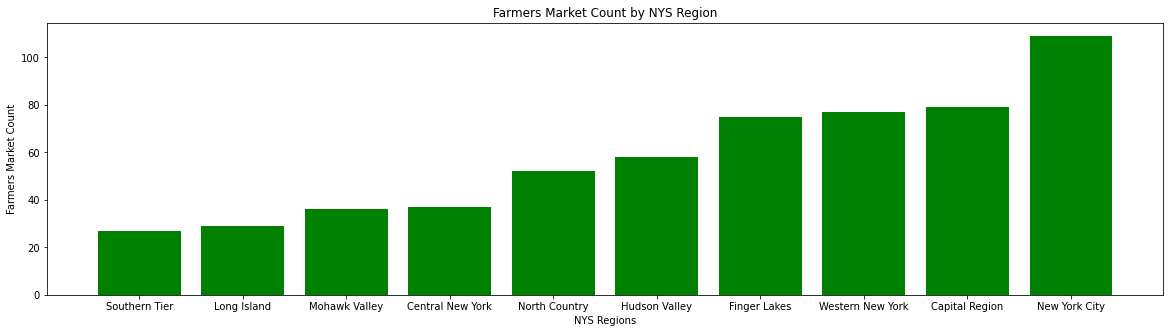

579

In [17]:
plt.figure(figsize=(20,5))
plt.bar(nyregions['Region'],nyregions['Farmers Market Count'], color='g')
plt.xlabel('NYS Regions')
plt.ylabel('Farmers Market Count')
plt.title('Farmers Market Count by NYS Region')
plt.show()

dfreg_markets['Farmers Market Count'].sum()

In [18]:
nyregions

,Region,Farmers Market Count,Total Population,Number in Poverty,Percent in Poverty,Median Household Income,Percent of Total Pop,Percent of Farmers Market
8,Southern Tier,27,592155.0,83690.0,102.8,450971,3.497640,4.663212
4,Long Island,29,2778054.0,163320.0,11.8,231814,6.825602,5.008636
5,Mohawk Valley,36,458500.0,56966.0,74.1,344637,2.380769,6.217617
1,Central New York,37,736851.0,93215.0,60.8,306281,3.895717,6.390328
7,North Country,52,381843.0,49763.0,85.1,398825,2.079736,8.981002
3,Hudson Valley,58,2253938.0,217446.0,72.0,590474,9.087679,10.017271
2,Finger Lakes,75,1153844.0,144842.0,100.7,540968,6.053354,12.953368
9,Western New York,77,1333537.0,177970.0,71.1,269804,7.437866,13.298791
0,Capital Region,79,1042938.0,102434.0,80.4,546368,4.281005,13.644214
6,New York City,109,8108939.0,1311496.0,79.4,362891,54.811103,18.825561


In [19]:

plt.boxplot(nyregions['Percent in Poverty(NYS)'])
plt.show()
plt.pie(nyregions['Percent of Farmers Market'])
plt.show()
plt.pie(nyregions['Percent in Poverty(NYS)'])
plt.legend(loc="upper left")
plt.show()
plt.title('')

KeyError: ignored

In [ ]:
nys_total_pop = dfreg_markets['Total Population'].sum()

dfreg_markets['Percent in Poverty(NYS)'] = (dfreg_markets['Number in Poverty']/nys_total_pop)*100

dfreg_markets.groupby(['Region']).plot(kind='bar', y='Percent in Poverty(NYS)')
dfreg_markets

In [ ]:
### Farmers Markets per County

plt.figure(figsize=(10,14))
plt.barh(dfmerge['County'],dfmerge['Farmers Market Count'])
plt.xlabel('# of Farmers Markets', )
plt.ylabel('Counties')
plt.title('NYS Farmers Markets per County')

plt.show()

In [ ]:
# income bins




plt.hist(dfreg_markets['Median Household Income'], bins=5)
plt.show()


below_mean = dfreg_markets[(dfreg_markets['Median Household Income'] <= dfreg_markets['Median Household Income'].mean() )]
above_mean = dfreg_markets[(dfreg_markets['Median Household Income'] > dfreg_markets['Median Household Income'].mean() )]
plt.hist(below_mean)
# dfreg_markets['Median Household Income'].mean()